In [2]:
import pandas as pd

spotify = pd.read_csv('/content/drive/MyDrive/TCC Dataset/spotify_songs_2010_2019_normalized.csv')

df_pop = spotify[spotify['genre'].str.contains('^pop,', regex=True)]
df_hip_hop = spotify[spotify['genre'].str.contains('^hip hop,', regex=True)]

df_pop['genre'] = 'pop'
df_hip_hop['genre'] = 'hip hop'

df = pd.concat([df_pop, df_hip_hop])

<ipython-input-2-1c2b0cab1d73>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pop['genre'] = 'pop'
<ipython-input-2-1c2b0cab1d73>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hip_hop['genre'] = 'hip hop'


In [ ]:
from numpy.ma.core import sqrt

def attribute_relevance(df1, df2, list_attr):
  dict_attributes = {}

  for attr in list_attr:
    delta = sqrt((df1[attr].var()/len(df1)) + (df2[attr].var()/len(df2)))
    dict_attributes[attr] = abs((df1[attr].mean() - df2[attr].mean())/delta)

  return dict_attributes

list_attribute = ['explicit', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

sorted_dict = sorted(attribute_relevance(df_pop, df_hip_hop, list_attribute).items(), key=lambda x: x[1])
print(sorted_dict)

[('mode', 0.4280315320097527), ('loudness', 0.8910762915555778), ('liveness', 1.0120734795393758), ('tempo', 1.4754798700656655), ('valence', 1.9485701635923491), ('key', 2.050542611786265), ('energy', 2.7022415420861896), ('acousticness', 3.042595776820854), ('instrumentalness', 3.2087586201177607), ('duration_ms', 5.026437272276415), ('danceability', 8.93121070555781), ('speechiness', 12.806903879037689), ('explicit', 18.31378405199911)]


In [3]:
del df['artist']
del df['song']
del df['duration_ms']
# del df['explicit']
del df['year']
del df['popularity']
# del df['danceability']
del df['energy']
del df['key']
del df['loudness']
del df['mode']
# del df['speechiness']
del df['acousticness']
del df['instrumentalness']
del df['liveness']
del df['valence']
del df['tempo']
# del df['genre']

## Decision tree

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

num_dim = len(df.columns) - 1
label_enc = LabelEncoder()

X = df.iloc[:,0:num_dim]
y = label_enc.fit_transform(df.iloc[:,-1])

X['explicit'] = LabelEncoder().fit_transform(df.iloc[:,0:1])

#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree

parameters = {'max_depth':range(3,20)}

clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=5)
spotify = clf.fit(X=X, y=y)
tree_model = clf.best_estimator_

print(clf.best_score_, clf.best_params_, clf.best_params_.get('max_depth'))

0.7232758620689655 {'max_depth': 3} 3


Acurácia (base de treinamento): 0.7459770114942529
Acurácia de previsão: 0.7103448275862069
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       155
           1       0.70      0.67      0.68       135

    accuracy                           0.71       290
   macro avg       0.71      0.71      0.71       290
weighted avg       0.71      0.71      0.71       290

         Hip hop(prev)  Pop(prev)
Hip hop            116         39
Pop                 45         90


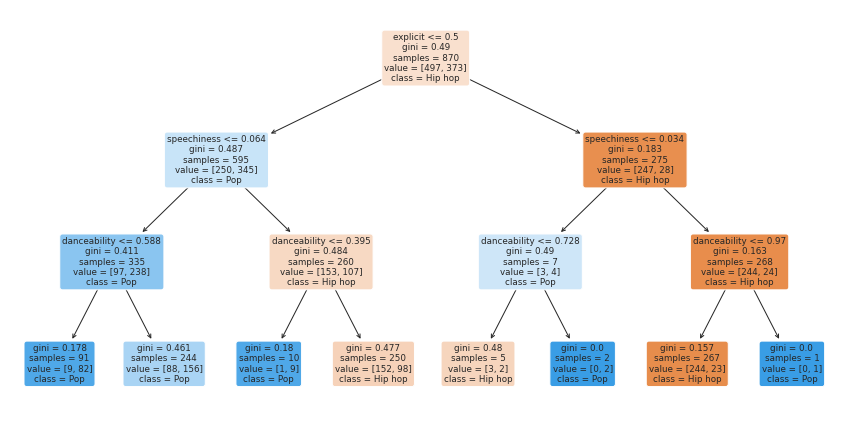

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

tree_spotify = DecisionTreeClassifier(max_depth=clf.best_params_.get('max_depth'))
tree_spotify = tree_spotify.fit(X_train, y_train)
print("Acurácia (base de treinamento):", tree_spotify.score(X_train, y_train))

y_pred = tree_spotify.predict(X_test)
print("Acurácia de previsão:", accuracy_score(y_test, y_pred))

names = ['Hip hop', 'Pop']

plt.figure(figsize=(15, 7.5))
plot_tree(tree_spotify,
          filled=True,
          rounded=True,
          class_names=names,
          feature_names=X.columns)

print(classification_report(y_test, y_pred))

#matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_table = pd.DataFrame(data=cnf_matrix, index=names, columns=[x + "(prev)" for x in names])
print(cnf_table)

## Cost Complexity Pruning

In [ ]:
path = tree_spotify.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]
print(ccp_alphas)
tree_spotify_ccp = []

for ccp_alpha in ccp_alphas:
  tree_spotify = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
  tree_spotify.fit(X_train, y_train)
  tree_spotify_ccp.append(tree_spotify)

[0.         0.00118227 0.00191269 0.00364151 0.01043965 0.01253385
 0.03006705]


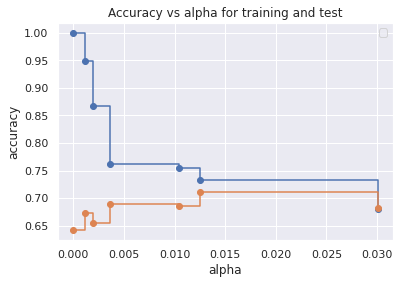

In [ ]:
train_scores = [tree_spotify.score(X_train, y_train) for tree_spotify in tree_spotify_ccp]
test_scores = [tree_spotify.score(X_test, y_test) for tree_spotify in tree_spotify_ccp]

fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs alpha for training and test')
ax.plot(ccp_alphas, train_scores, marker='o', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', drawstyle='steps-post')
ax.legend()
plt.show()

### Using Cross validation to find the best alpha

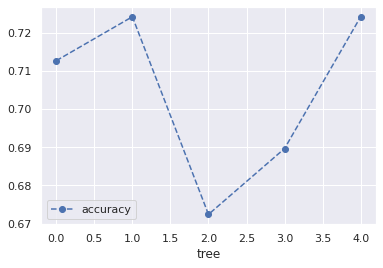

In [ ]:
import numpy as np

tree_spotify = DecisionTreeClassifier(ccp_alpha=0.030)

scores = cross_val_score(tree_spotify, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree':range(5), 'accuracy': scores})

df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

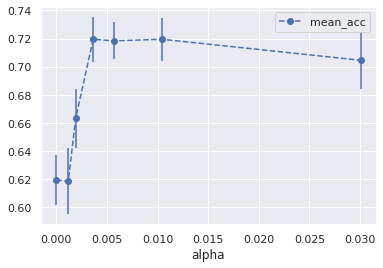

In [ ]:
alpha_values = []

for ccp_alpha in ccp_alphas:
  tree_spotify = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
  scores = cross_val_score(tree_spotify, X_train, y_train, cv=5)
  alpha_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'mean_acc', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_acc',
                   yerr='std',
                   marker='o',
                   linestyle='--')

In [ ]:
best_alpha = alpha_results[(alpha_results['alpha'] >= 0.002) & (alpha_results['alpha'] < 0.005)]['alpha']
best_alpha

3    0.003642
Name: alpha, dtype: float64